<a href="https://colab.research.google.com/github/ccwu0918/classify_image/blob/main/classify_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

金門具有代表性的栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺五種物種。我們來挑戰五種類別總共用五十張照片, 看能不能打造一個神經網路學會辨識這五種類別。

In [8]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### 1. 讀入栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺資料圖檔


In [1]:
!git clone https://github.com/ccwu0918/classify_image.git

Cloning into 'classify_image'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (57/57), 920.46 KiB | 3.49 MiB/s, done.


In [10]:
base_dir = './classify_image/'

In [18]:
image_folders = ['Merops_philippinus', 'pavo_cristatus', 'Upupa_epops', 'King_Crab', 'otter']

為了後面的需要，我們將五種類別照片的答案用 `labels` 呈現

In [64]:
labels = ["栗喉蜂虎", "藍孔雀", "戴勝", "鱟", "歐亞水獺"]

In [63]:
num_classes = len(labels)

我們可以列出在某個圖片資料夾的檔名! 比方說「栗喉蜂虎」是這樣。

In [20]:
thedir = base_dir + image_folders[0]
os.listdir(thedir)

['Merops_philippinus_04.jpg',
 'Merops_philippinus_10.jpg',
 'Merops_philippinus_08.jpg',
 'Merops_philippinus_06.jpg',
 'Merops_philippinus_09.jpg',
 'Merops_philippinus_05.jpg',
 'Merops_philippinus_01.jpg',
 'Merops_philippinus_03.jpg',
 'Merops_philippinus_02.jpg',
 'Merops_philippinus_07.jpg']

接下來，我們要將這五個資料夾底下的照片當作輸入 (data)、輸出 (target)。

In [66]:
data = []
target = []
for i in range(num_classes):
    thedir = base_dir + image_folders[i]
    image_fnames = os.listdir(thedir)
    for theimage in image_fnames:
        if theimage == ".git" or theimage == ".ipynb_checkpoints":
          continue
        img_path = thedir + '/' + theimage
        img = load_img(img_path , target_size = (256,256))
        x = img_to_array(img)
        data.append(x)
        target.append(i)

In [67]:
data = np.array(data)

順便看一下我們總共有多少張圖片。

In [68]:
data.shape

(50, 256, 256, 3)

接著，隨便挑一張照片來看看它是什麼長什麼模樣

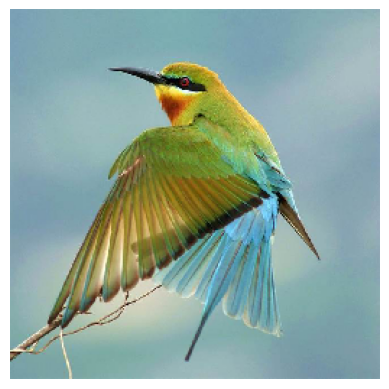

In [69]:
n = 6 # 第6張照片
plt.imshow(data[n]/255)
plt.axis('off');

看來沒有什麼意外，就是張「栗喉蜂虎」的照圖。我們用 ResNet 的預處理再看一次。

### 2. 針對資料圖檔使用 ResNet 進行預處理

In [31]:
x_train = preprocess_input(data)

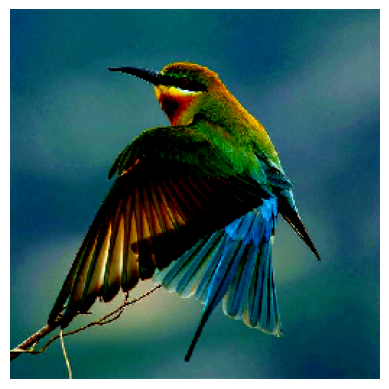

In [33]:
plt.imshow(x_train[n])
plt.axis('off');

這邊會跳出一個小小的警告，這是因為 ResNet 的預處理會將圖片的數據範圍常規化到 [-1, 1] 之間，與我們之前常規化到 [0, 1] 之間差一點點，所以畫圖時，matplotlib會自動作一些調整。

每張圖的答案就是 0, 1, 2, 3, 4其中一個數字。

In [70]:
target[n]

0

做 one-hot enconding。

In [72]:
y_train = to_categorical(target, num_classes)

In [73]:
y_train[0]

array([1., 0., 0., 0., 0.], dtype=float32)

### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺五種物種, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global average pooling), 這本來該我們自己做, 但是 `tf.Keras` 是善良無比的幫我們做好。只要下個參數 `pooling="avg"`)。

In [37]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [38]:
resnet = ResNet50V2(include_top=False, pooling="avg")

94668760/94668760 [==============================] - 5s 0us/step


再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後



In [39]:
model = Sequential()

In [40]:
model.add(resnet)

In [41]:
model.add(Dense(5, activation='softmax')) # 這裡的 5 表示，輸出結果為 5 個類別

我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [42]:
resnet.trainable = False

#### 欣賞我們的神經網路

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法，當然也可以試試 `sgd` 看效果如何。

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

我們可以發現原來有超過兩千萬個參數, 經我們借來以後, 只有 1,0245 個參數要調。

### 4. 訓練 fit

這裡我們全部的資料也只有 50 筆, 所以 `batch_size` 就選擇 25 了，同時訓練的回合數設定為 10 回合

In [50]:
model.fit(x_train, y_train, batch_size=25, epochs=10)

Epoch 1/10
2/2 [==============================] - 13s 88ms/step - loss: 1.3688 - accuracy: 0.3600
Epoch 2/10
2/2 [==============================] - 0s 87ms/step - loss: 0.8368 - accuracy: 0.7200
Epoch 3/10
2/2 [==============================] - 0s 89ms/step - loss: 0.4997 - accuracy: 0.9400
Epoch 4/10
2/2 [==============================] - 0s 85ms/step - loss: 0.2962 - accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 88ms/step - loss: 0.1745 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 88ms/step - loss: 0.1080 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 87ms/step - loss: 0.0695 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 88ms/step - loss: 0.0467 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 88ms/step - loss: 0.0342 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 85ms/step - loss: 0.0261 - accuracy: 1.0000


### 5. 預測

我們先用 model.evaluate 看一下模型表現得如何

In [51]:
loss, acc = model.evaluate(x_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

2/2 [==============================] - 4s 1s/step - loss: 0.0214 - accuracy: 1.0000
Loss: 0.021386565640568733
Accuracy: 1.0


對了, 為何這次我們沒有切測試一一資料呢? 那是因為畢竟我們全部只有 50 張照片，而且每種類別照片也只有10張。我們可以看一下訓練成果。

In [52]:
y_predict = np.argmax(model.predict(x_train), -1)

2/2 [==============================] - 1s 140ms/step


In [53]:
y_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

好奇的話比較一下正確答案。

In [56]:
print(list(target))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


### 6. 將訓練完成的模型儲存起來，可供日後直接略過訓練直接載入訓練完成的模型進行辨識。

In [82]:
model.save('my_cnn_model.h5')

### 7. 載入並檢視訓練完成的模型。

In [83]:
model = load_model('my_cnn_model.h5') # Loading the Tensorflow Saved Model (PB)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________
None


### 8. 用 `gradio` 打造栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺辨識 Web App!




In [ ]:
!pip install gradio

In [60]:
import gradio as gr

注意現在主函數做辨識只有五個種類。而且是使用我們自行訓練的 model!

In [74]:
def classify_image(inp):
    inp = inp.reshape((-1, 256, 256, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(num_classes)}

In [75]:
image = gr.Image(shape=(256, 256), label="栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺照片")
label = gr.Label(num_top_classes=num_classes, label="AI ResNet50V2遷移式學習辨識結果")
some_text="我能辨識金門栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺。找張金門栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺照片來考我吧!"

我們將金門栗喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺數據庫中的圖片拿出來當作範例圖片讓使用者使用

In [78]:
sample_images = []
for i in range(num_classes):
    thedir = base_dir + image_folders[i]
    for file in os.listdir(thedir):
        if file == ".git" or file == ".ipynb_checkpoints":
          continue
        sample_images.append(base_dir + image_folders[i] + '/' + file)

最後，將所有東西組裝在一起，就大功告成了！

In [84]:
gr.Interface(fn=classify_image,
             inputs=image,
             outputs=label,
             title="AI 喉蜂虎、藍孔雀、戴勝、鱟及歐亞水獺辨識機",
             description=some_text,
             examples=sample_images, live=True).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1c2b2c37ef1d7f5a8a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
